# SwissVotes - Analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import re

## Data cleaning

In [2]:
df_full = pd.read_csv('swiss-votes.csv', delimiter=';', dtype={
    'volk': 'string',
    'stand': 'string',
    'annahme': 'string',
})
df_full.head()

,anr,datum,titel_kurz_d,titel_kurz_f,titel_kurz_e,titel_off_d,titel_off_f,stichwort,swissvoteslink,anzahl,...,bkresults-fr,bfsdash-de,bfsdash-fr,bfsdash-en,bfsmap-de,bfsmap-fr,bfsmap-en,nach_cockpit_d,nach_cockpit_f,nach_cockpit_e
0,1.0,12.09.1848,Bundesverfassung der schweizerischen Eidgenoss...,Constitution fédérale de la Confédération suisse,Federal Constitution of the Swiss Confederation,Totalrevision vom 12. September 1848,Révision totale du 12 septembre 1848,.,https://swissvotes.ch/vote/1.00,1,...,https://www.bk.admin.ch/ch/f/pore/va/18480606/...,.,.,.,NaN,NaN,.,.,.,.
1,2.0,14.01.1866,Mass und Gewicht,Poids et mesures,Weights and measures,Festsetzung von Mass und Gewicht,Poids et mesures,.,https://swissvotes.ch/vote/2.00,9,...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,.,.,.,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.,.
2,3.0,14.01.1866,Gleichstellung der Juden und Naturalisierten m...,Egalité des Juifs,Equal rights for Jews and naturalised citizens...,Gleichstellung der Juden und Naturalisierten m...,Egalité des citoyens au point de vue de l'étab...,.,https://swissvotes.ch/vote/3.00,9,...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,.,.,.,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.,.
3,4.0,14.01.1866,Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",Swiss residents' right to vote in communal mat...,Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",.,https://swissvotes.ch/vote/4.00,9,...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,.,.,.,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.,.
4,5.0,14.01.1866,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,Taxation and civil law status of Swiss residents,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,.,https://swissvotes.ch/vote/5.00,9,...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,.,.,.,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.,.


In [3]:
df = pd.DataFrame()
df['title_fr'] = df_full['titel_off_f'] # Title of the vote in French
df['date'] = pd.to_datetime(df_full['datum'], dayfirst=True)
df['date_year'] = df['date'].dt.year
df['type'] = df_full['rechtsform'].map({
    1: 'mandatory-referendum',
    2: 'optional-referendum',
    3: 'popular-initiative',
    4: 'AA',
    5: 'BB'
})
df['author'] = df_full['urheber']
df['author_fr'] = df_full['urheber-fr']
df['valid_signatures'] = df_full['unter_g']

df['main_theme'] = df_full['d1e1']
df['result_people'] = df_full['volk']
df['result_cantons'] = df_full['stand']
df['result'] = df_full['annahme']

df

,title_fr,date,date_year,type,author,author_fr,valid_signatures,main_theme,result_people,result_cantons,result
0,Révision totale du 12 septembre 1848,1848-09-12,1848,mandatory-referendum,.,.,.,1,1,1,1
1,Poids et mesures,1866-01-14,1866,mandatory-referendum,.,.,.,1,1,0,0
2,Egalité des citoyens au point de vue de l'étab...,1866-01-14,1866,mandatory-referendum,.,.,.,12,1,1,1
3,"Droit de vote des Suisses établis, en matière ...",1866-01-14,1866,mandatory-referendum,.,.,.,1,0,0,0
4,Impôts et rapports civils des Suisses établis,1866-01-14,1866,mandatory-referendum,.,.,.,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
684,Initiative populaire «Pour une prévoyance viei...,2024-03-03,2024,popular-initiative,Jungfreisinnige,Jeunes Libéraux-radicaux (JLR),107049,10,0,0,0
685,Initiative populaire «Maximum 10 % du revenu p...,2024-06-09,2024,popular-initiative,SP,PS,101780,10,<NA>,<NA>,<NA>
686,Initiative populaire «Pour des primes plus bas...,2024-06-09,2024,popular-initiative,Die Mitte / CVP,Le Centre / PDC,103761,10,<NA>,<NA>,<NA>
687,Initiative populaire «Pour la liberté et l’int...,2024-06-09,2024,popular-initiative,Freiheitliche Bewegung Schweiz,Mouvement suisse pour la liberté,125015,1,<NA>,<NA>,<NA>


### Political parties

In [4]:
def has_svp(authors): # UDC: Union Democrate du Centre
    authors = authors.lower()
    return "schweizerische volkspartei" in authors or re.search(r'\bsvp\b', authors) is not None

def has_sp(authors): # PS: Parti Socialiste
    authors = authors.lower()
    return "sozialdemokratischen partei" in authors \
        or "sozialdemokratische partei" in authors \
        or re.search(r'\bsp\b', authors) is not None

def has_mitte(authors): # Partis centristes
    authors = authors.lower()
    return re.search(r'\b(cvp|bdp)\b', authors) is not None

def has_fdp(authors): # Parti libéral-démocrate
    authors = authors.lower()
    return re.search(r'\bfdp\b', authors) is not None

def has_grun(authors): # Partis verts
    authors = authors.lower().replace('ü', 'u')
    return re.search(r'\bgrun(e|en|es)?\b', authors) is not None

def has_uss(authors): # Union syndicale suisse
    authors = authors.lower()
    return 'sgb' in authors or re.search(r'schweizerische(n|r) gewerk?schaftsbund', authors) is not None

df['author_svp'] = df['author'].map(has_svp)
df['author_sp'] = df['author'].map(has_sp)
df['author_mitte'] = df['author'].map(has_mitte)
df['author_fdp'] = df['author'].map(has_fdp)
df['author_grun'] = df['author'].map(has_grun)
df['author_uss'] = df['author'].map(has_uss)

df['author_partei'] = df['author_svp'] | df['author_sp'] | df['author_mitte'] | df['author_fdp'] | df['author_grun']

FULL_NAMES = {
    'svp': "Swiss People's Party",
    'sp': "Social Democratic Party",
    'mitte': "The Centre",
    'fdp': "Free Democratic Party",
    'grun': "Green Party of Switzerland",
    'uss': "Swiss Trade Union Federation"
}

In [5]:
df['date_year'].describe()

count     689.000000
mean     1974.236575
std        39.673127
min      1848.000000
25%      1953.000000
50%      1985.000000
75%      2003.000000
max      2024.000000
Name: date_year, dtype: float64

No author is provided for mandatory referendums (since the referendum is not initiated by a specific group of people). A negligible number of votes of another type also miss this information.

In [6]:
# Missing data
df.query("type != 'mandatory-referendum' & author == '.'")

,title_fr,date,date_year,type,author,author_fr,valid_signatures,main_theme,result_people,result_cantons,result,author_svp,author_sp,author_mitte,author_fdp,author_grun,author_uss,author_partei
19,Loi fédérale accordant des subventions aux che...,1879-01-19,1879,optional-referendum,.,.,36062,8,1,3,1,False,False,False,False,False,False,False
34,Loi fédérale concernant les fonctionnaires et ...,1891-03-15,1891,optional-referendum,.,.,84572,1,0,3,0,False,False,False,False,False,False,False
64,Loi fédérale sur le commerce des denrées alime...,1906-06-10,1906,optional-referendum,.,.,57354,4,1,3,1,False,False,False,False,False,False,False
84,Loi fédérale concernant la durée du travail da...,1920-10-31,1920,optional-referendum,.,.,59808,4,1,3,1,False,False,False,False,False,False,False
134,Loi fédérale modifiant le statut des fonctionn...,1939-12-03,1939,optional-referendum,.,.,40379,1,0,3,0,False,False,False,False,False,False,False
140,Loi fédérale sur les chemins de fer fédéraux,1945-01-21,1945,optional-referendum,.,.,35493,8,1,3,1,False,False,False,False,False,False,False
146,Loi fédérale sur l'assurance-vieillesse et sur...,1947-07-06,1947,optional-referendum,.,.,55424,10,1,3,1,False,False,False,False,False,False,False
266,Arrêté fédéral concernant la conclusion d'un a...,1976-06-13,1976,optional-referendum,.,.,38238,2,0,3,0,False,False,False,False,False,False,False
351,Contre-projet à l'initiative populaire «en fav...,1986-09-28,1986,AA,.,.,.,12,0,0,0,False,False,False,False,False,False,False
360,Arrêté fédéral concernant le projet RAIL 2000,1987-12-06,1987,optional-referendum,.,.,82708,8,1,3,1,False,False,False,False,False,False,False


In [7]:
df_initiatives = df.query("type == 'popular-initiative'")

print('Percentage of popular initiatives from a political party', df_initiatives['author_partei'].sum() / len(df_initiatives))

Percentage of popular initiatives from a political party 0.28205128205128205


In [8]:
print("Number of initiatives per party:")

for id in FULL_NAMES:
    print(FULL_NAMES[id], sum(df_initiatives[f'author_{id}']))

Number of initiatives per party:
Swiss People's Party 14
Social Democratic Party 41
The Centre 3
Free Democratic Party 3
Green Party of Switzerland 12
Swiss Trade Union Federation 17


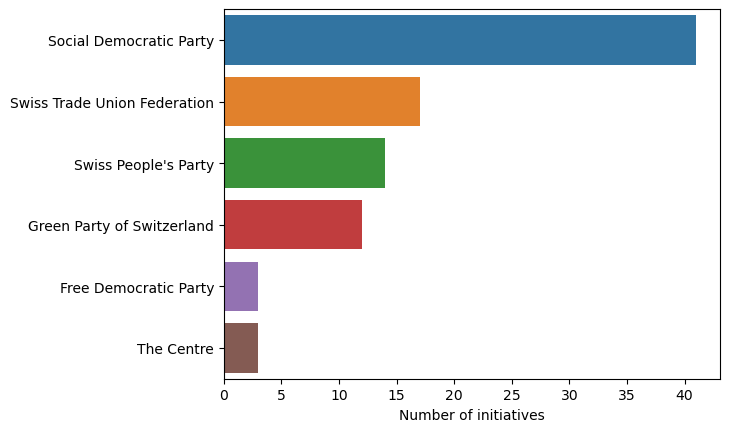

In [9]:
def plot():
    data = []
    for id in ['sp', 'uss', 'svp', 'grun', 'fdp', 'mitte']:
        data.append({'party': FULL_NAMES[id], 'count': sum(df_initiatives[f'author_{id}'])})

    df_data = pd.DataFrame(data)
    ax = sns.barplot(df_data, y="party", x="count")
    ax.set(xlabel='Number of initiatives', ylabel=None)
    plt.savefig('output/total-initiatives-by-party.png', bbox_inches='tight')
    plt.show()

plot()

In [10]:
for _, row in df_initiatives.iterrows():
    aut = row['author']
    if 'partei' in aut.lower() and not row['author_partei']:
        print(aut)

Kommunistische Partei
Liberalsozialistische Partei
Partei der Arbeit
Partei der Arbeit
Initiativkomitee für einen wirksamen Schutz der Mutterschaft (10 Organisationen: Frauenorganisationen, Gewerkschaften, linke Parteien)
Aktionskomitee für eine gesicherte Berufsbildung und Umschulung (Sozialistische Arbeiterpartei)
Fédération Suisse des locataires, Union des Producteurs Suisses, Umweltorganisationen und Linksparteien
Ad-hoc-Komitee (Politiker bürgerlicher und rechter Parteien, Prominente aus Sport und Unterhaltung, unterstützt vom Verein zur Förderung der psychologischen Menschenkenntnis )
Ad-hoc-Komitee (Persönlichkeiten verschiedener Parteien, Organisationen "Helfen statt töten", "Rede mitenand", "Ja zum Leben")
überparteiliches Komitee
Linke Parteien und Gewerkschaften
parteipolitisch unabhängiges Komitee


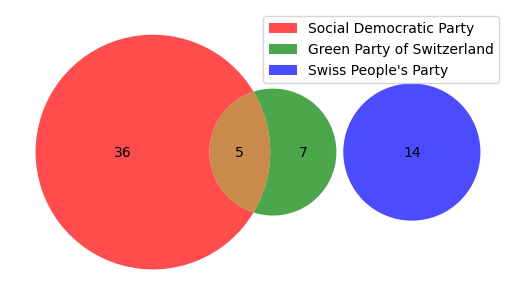

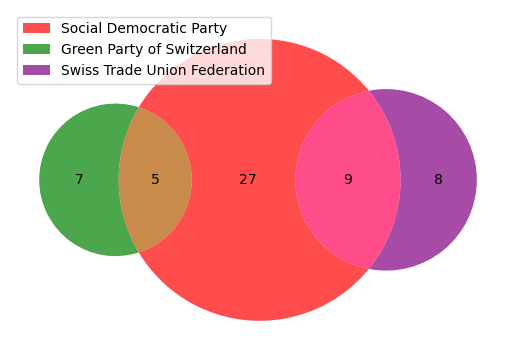

In [11]:
from collections import Counter
from matplotlib_venn import venn3

def plot_join_initiatives(ids, columns, colors, output_file):
    counter = Counter()

    for _, row in df_initiatives.iterrows():
        votes = (row[columns[0]], row[columns[1]], row[columns[2]])

        if votes != (0, 0, 0):
            counter.update([votes])

    plt.figure()
    ax = plt.gca()

    v = venn3(
        subsets=(counter[(True, False, False)], counter[(False, True, False)], counter[(True, True, False)], counter[(False, False, True)], counter[(True, False, True)], counter[(False, True, True)], counter[(True, True, True)]),
        set_labels=None,
        ax=ax,
        set_colors=colors
    )

    for id in ['001', '010', '011', '100', '101', '110', '111']:
        try:
            v.get_patch_by_id(id).set_alpha(0.7)
        except:
            pass

    
    h = [v.get_patch_by_id('100'), v.get_patch_by_id('010'), v.get_patch_by_id('001')]
    l = [FULL_NAMES[id] for id in ids]
    ax.legend(handles=h, labels=l)

    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

plot_join_initiatives(['sp', 'grun', 'svp'], ('author_sp', 'author_grun', 'author_svp'), ('red', 'green', 'blue'), 'output/joint-initiatives-parties.png')
plot_join_initiatives(['sp', 'grun', 'uss'], ('author_sp', 'author_grun', 'author_uss'), ('red', 'green', 'purple'), 'output/joint-initiatives-uss.png')

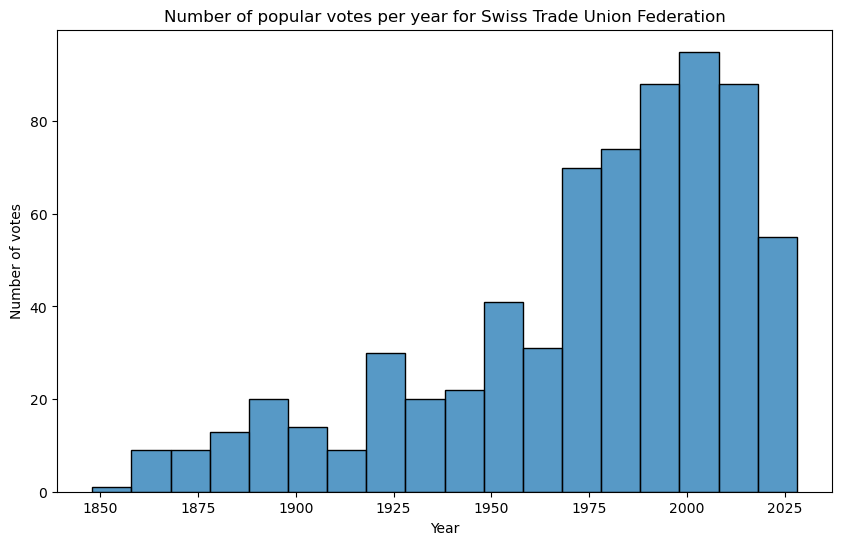

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['date_year'], binwidth=10)
plt.title(f"Number of popular votes per year for {FULL_NAMES[id]}")
plt.xlabel('Year')
plt.ylabel('Number of votes')
plt.show()

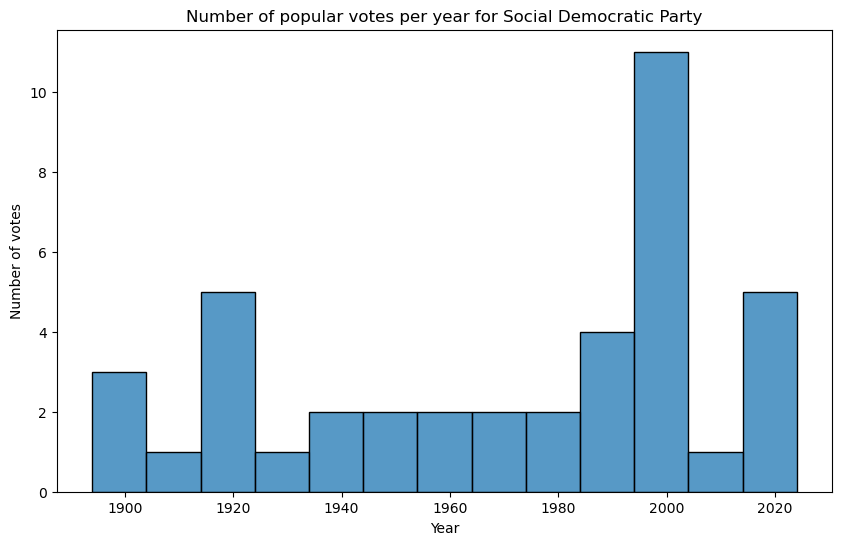

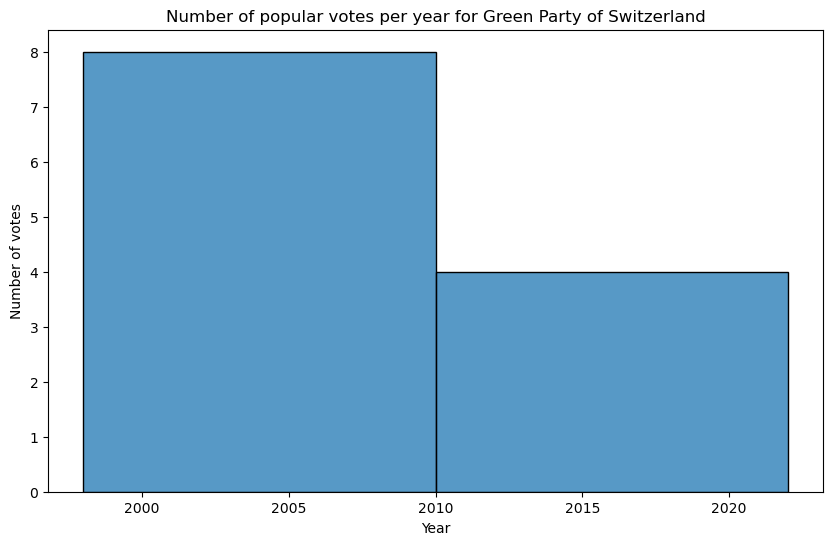

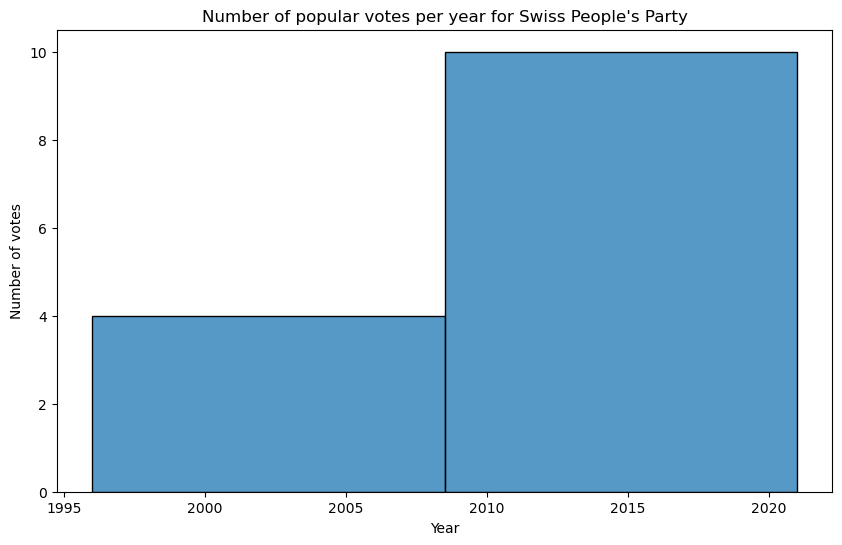

In [13]:
for id in ['sp', 'grun', 'svp']:
    df_party = df_initiatives.query(f"author_{id} == 1")
    plt.figure(figsize=(10, 6))
    sns.histplot(df_party['date_year'], bins=(df_party['date_year'].max()-df_party['date_year'].min()) // 10)
    plt.title(f"Number of popular votes per year for {FULL_NAMES[id]}")
    plt.xlabel('Year')
    plt.ylabel('Number of votes')
    plt.show()

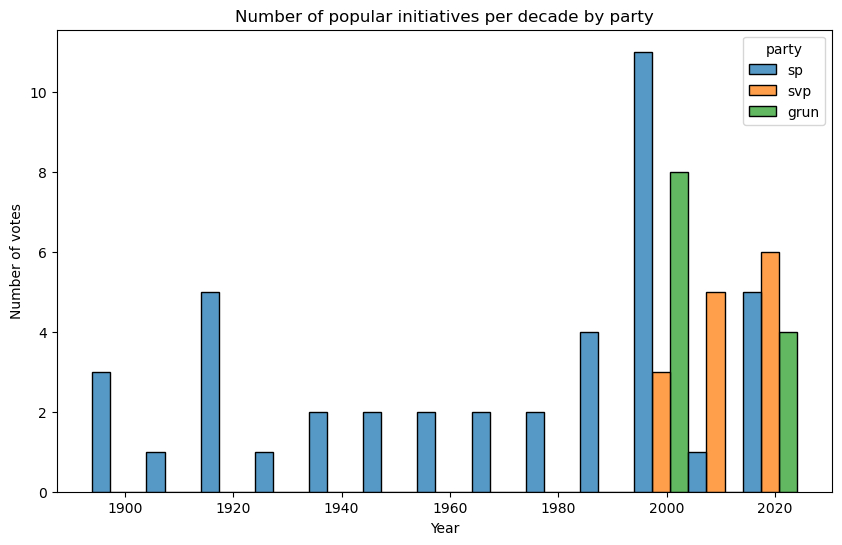

In [14]:
def plot():
    rows = []

    for id in ['sp', 'svp', 'grun']:
        for _, r in df_initiatives.query(f"author_{id} == 1").iterrows():
            rows.append({'year': r['date_year'], 'party': id})

    df_initiatives_parties = pd.DataFrame(rows, columns=['year', 'party'])

    plt.figure(figsize=(10, 6))

    sns.histplot(df_initiatives_parties, x='year', hue='party', multiple="dodge", binwidth=10)

    plt.title(f"Number of popular initiatives per decade by party")
    plt.xlabel('Year')
    plt.ylabel('Number of votes')
    plt.show()

plot()

## Analysis

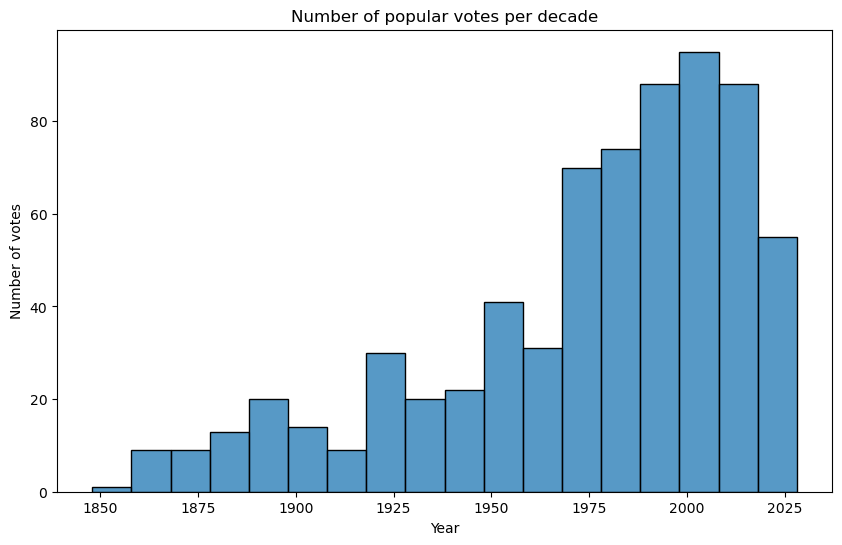

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df['date_year'], binwidth=10)
plt.title('Number of popular votes per decade')
plt.xlabel('Year')
plt.ylabel('Number of votes')
plt.show()

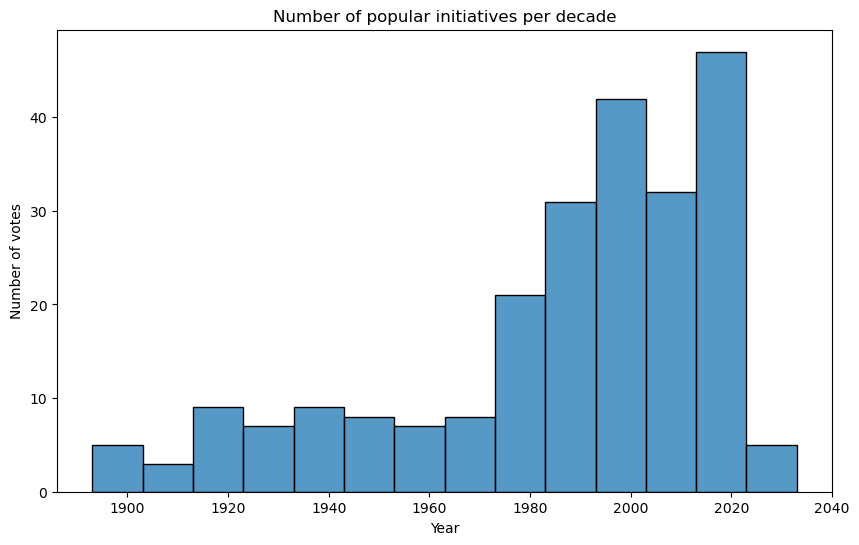

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df_initiatives['date_year'], binwidth=10)
plt.title('Number of popular initiatives per decade')
plt.xlabel('Year')
plt.ylabel('Number of votes')
plt.show()

/home/adrien/anaconda3/envs/epfl-ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


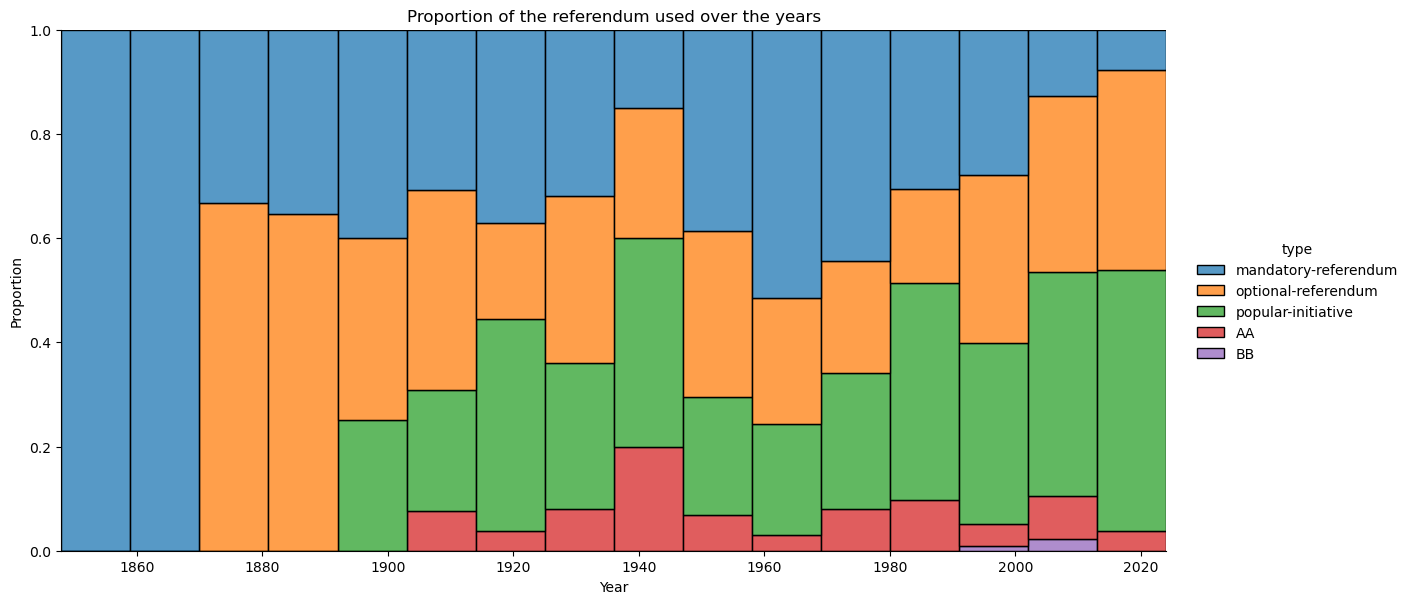

In [17]:
sns.displot(df, x='date_year', hue='type', kind='hist', multiple='fill', aspect=2, height=6)
plt.title("Proportion of the referendum used over the years")
plt.xlabel("Year")
plt.xlim(df['date_year'].min(), df['date_year'].max())
plt.ylabel("Proportion")
plt.show()

## Dimension reduction

In [18]:
from tqdm import tqdm

indices = [c for c in df_full.columns if c[:2] == 'p-' and c[2:8] != 'others']

# Filter out inactive entities
new_indices = []

for idx in indices:
    total = 0
    for _, r in df_full.iterrows():
        if str(r[idx]) in ['1', '2']:
            total += 1
    if total >= 200:
        new_indices.append(idx)

indices = new_indices

votes = [[{'pp': 0, 'pn': 0, 'np': 0, 'nn': 0} for _ in range(len(indices))] for _ in range(len(indices))]

for i1, idx1 in enumerate(tqdm(indices)):
    for i2, idx2 in enumerate(indices):
        for _, r in df_full.iterrows():
            if str(r[idx1]) == '1' and str(r[idx2]) == '1':
                votes[i1][i2]['pp'] += 1
            if str(r[idx1]) == '1' and str(r[idx2]) == '2':
                votes[i1][i2]['pn'] += 1
            if str(r[idx1]) == '2' and str(r[idx2]) == '1':
                votes[i1][i2]['np'] += 1
            if str(r[idx1]) == '2' and str(r[idx2]) == '2':
                votes[i1][i2]['nn'] += 1

def get_dist(votes):
    total = votes['pp'] + votes['nn'] + votes['np'] + votes['pn']
    return (votes['pn'] + votes['np']) / total

dists = [[get_dist(votes[i][j]) for i, _ in enumerate(votes)] for j, _ in enumerate(votes)]

100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


In [19]:
entity_names = {
    'p-fdp': "Free Democratic Party", # Freisinnig-demokratische Partei
    'p-sps': "Social Democratic Party", # Sozialdemokratische Partei
    'p-svp': "Swiss People's Party", # Schweizerische Volkspartei
    'p-evp': "Evangelical People's Party", # Evangelische Volkspartei
    'p-gps': "Green Party", # Grüne Partei der Schweiz
    'p-pda': "Swiss Party of Labour", # Partei der Arbeit
    'p-sd': "Swiss Democrats", # Schweizer Demokraten
    'p-edu': "Federal Democratic Union", # Eidgenössisch-Demokratische Union
    'p-fps': "Automobile Party", # Autopartei
    'p-cvp': "Christian Democratic People's Party", # Christlichdemokratische Volkspartei
    'p-lps': "Liberal Party", # Liberale Partei der Schweiz
    'p-ldu': "Alliance of Independents", # Landesring der Unabhängigen
    'p-eco': "Economiesuisse",
    'p-sgv': "Swiss Union of Arts and Crafts", # Schweizerischer Gewerbeverband
    'p-sbv': "Swiss Farmers' Union", # Schweizer Bauernverband
    'p-sgb': "Swiss Trade Union Federation", # Schweizerischer Gewerkschaftsbund
    'p-travs': "Travail.Suisse",
    'p-sav': "Swiss Employers Association", # Schweizerischer Arbeitgeberverband

    'p-bdp': "Conservative Democratic Party", # Bürgerlich-Demokratische Partei
    'p-kvp': "Catholic People's Party", # Katholische Volkspartei
}

In [20]:
# Agreement between sps and svp
for i, idx in enumerate(indices):
    if idx == 'p-svp':
        i_svp = i
    if idx == 'p-sps':
        i_sps = i

votes[i_sps][i_svp]

{'pp': 170, 'pn': 198, 'np': 126, 'nn': 47}

In [21]:
# 1D
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
data = pca.fit_transform(dists)

data = -data

perm = [(data[i], i) for i in range(len(indices))]
perm.sort()
perm = [i for d, i in perm]

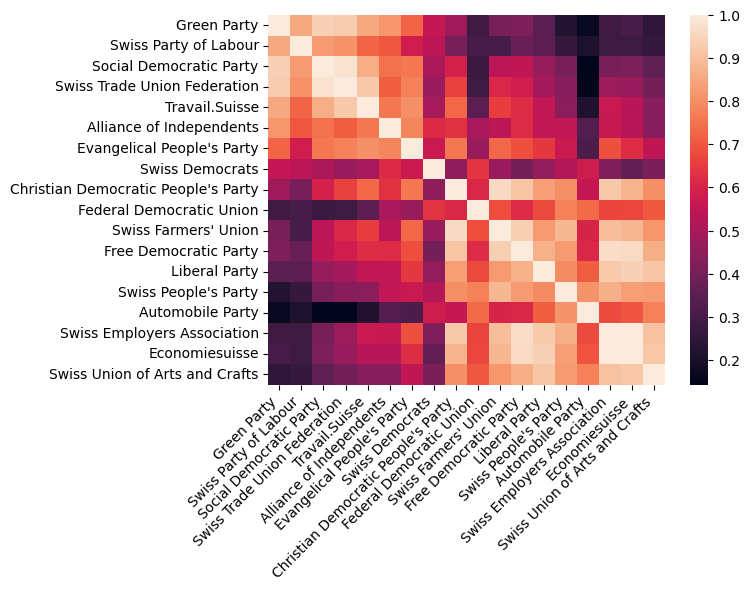

In [22]:
rows = []

for i in range(len(dists)):
    r = {'name': entity_names[indices[perm[i]]]}
    for j in range(len(dists)):
        agreement = 1 - dists[perm[i]][perm[j]]
        r[entity_names[indices[perm[j]]]] = agreement
    rows.append(r)

data = pd.DataFrame(rows)
data = data.set_index('name')
heatmap = sns.heatmap(data)
plt.xlabel(None)
plt.ylabel(None)
plt.setp(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig('output/heatmap-all-votes.png', bbox_inches='tight')
plt.show()

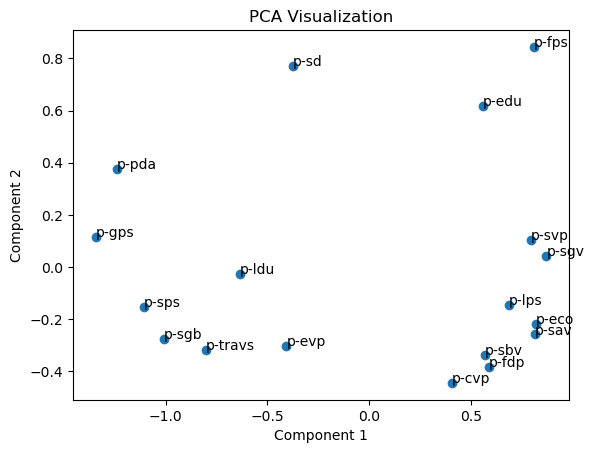

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data = pca.fit_transform(dists)

data[:, 0] = -data[:, 0]

plt.scatter(data[:, 0], data[:, 1])

for i, label in enumerate(indices):
    plt.annotate(label, (data[i, 0], data[i, 1]))

plt.title('PCA Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### Only recent votes

In [24]:
df_full_recent = df_full[pd.to_datetime(df_full['datum'], dayfirst=True).dt.year >= 2013]

In [25]:
from tqdm import tqdm

indices = [c for c in df_full_recent.columns if c[:2] == 'p-' and c[2:8] != 'others']

# Filter out inactive entities
new_indices = []

for idx in indices:
    total = 0
    for _, r in df_full_recent.iterrows():
        if str(r[idx]) in ['1', '2']:
            total += 1
    if total >= 50:
        new_indices.append(idx)

indices = new_indices

votes = [[{'pp': 0, 'pn': 0, 'np': 0, 'nn': 0} for _ in range(len(indices))] for _ in range(len(indices))]

for i1, idx1 in enumerate(tqdm(indices)):
    for i2, idx2 in enumerate(indices):
        for _, r in df_full_recent.iterrows():
            if str(r[idx1]) == '1' and str(r[idx2]) == '1':
                votes[i1][i2]['pp'] += 1
            if str(r[idx1]) == '1' and str(r[idx2]) == '2':
                votes[i1][i2]['pn'] += 1
            if str(r[idx1]) == '2' and str(r[idx2]) == '1':
                votes[i1][i2]['np'] += 1
            if str(r[idx1]) == '2' and str(r[idx2]) == '2':
                votes[i1][i2]['nn'] += 1

def get_dist(votes):
    total = votes['pp'] + votes['nn'] + votes['np'] + votes['pn']
    return (votes['pn'] + votes['np']) / total

dists = [[get_dist(votes[i][j]) for i, _ in enumerate(votes)] for j, _ in enumerate(votes)]

100%|██████████| 16/16 [00:02<00:00,  6.61it/s]


In [26]:
# 1D
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
data = pca.fit_transform(dists)

perm = [(data[i], i) for i in range(len(indices))]
perm.sort()
perm = [i for d, i in perm]

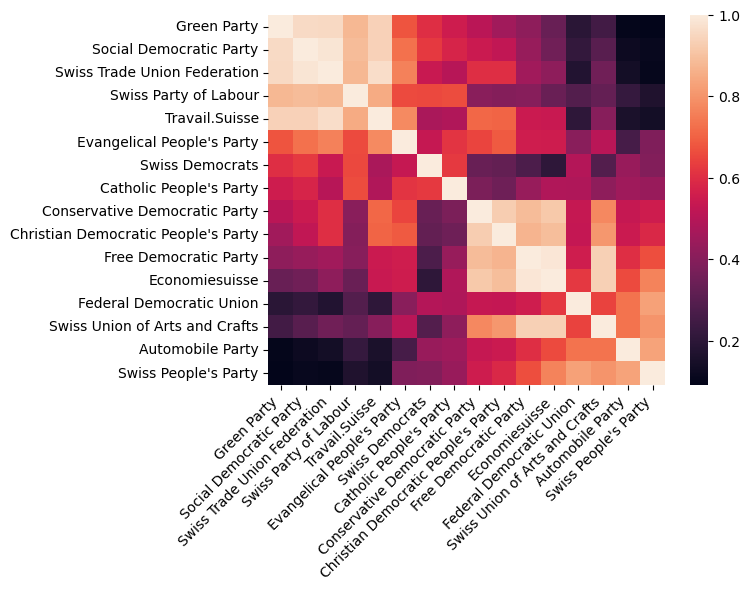

In [27]:
rows = []

for i in range(len(dists)):
    r = {'name': entity_names[indices[perm[i]]]}
    for j in range(len(dists)):
        agreement = 1 - dists[perm[i]][perm[j]]
        r[entity_names[indices[perm[j]]]] = agreement
    rows.append(r)

data = pd.DataFrame(rows)
data = data.set_index('name')
heatmap = sns.heatmap(data)
plt.xlabel(None)
plt.ylabel(None)
plt.setp(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig('output/heatmap-recent-votes.png', bbox_inches='tight')
plt.show()

## Better PCA

In [28]:
indices = [c for c in df_full.columns if c[:2] == 'p-' and c[2:8] != 'others']

# Filter out inactive entities
new_indices = []

for idx in indices:
    total = 0
    for _, r in df_full.iterrows():
        if str(r[idx]) in ['1', '2']:
            total += 1
    if total >= 200:
        new_indices.append(idx)

indices = new_indices

votes = np.zeros((len(indices), len(df_full)))

for i, (_, row) in enumerate(df_full.iterrows()):
    for j, idx in enumerate(indices):
        if str(row[idx]) == '1':
            votes[j, i] = -1
        elif str(row[idx]) == '2':
            votes[j, i] = 1

[0.37482926 0.16170268]


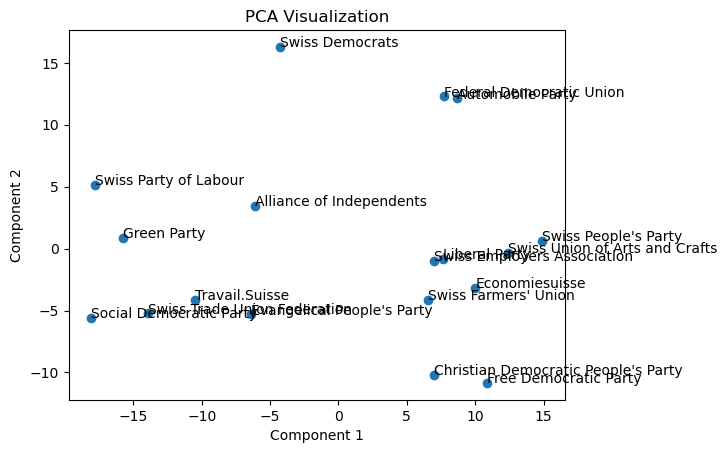

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data = pca.fit_transform(votes)

print(pca.explained_variance_ratio_)

data[:, 0] = -data[:, 0]

plt.scatter(data[:, 0], data[:, 1])

for i, label in enumerate(indices):
    plt.annotate(entity_names[label], (data[i, 0], data[i, 1]))

plt.title('PCA Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# Export the dataset

In [30]:
df_export = df[['date_year', 'type', 'author_svp', 'author_sp', 'author_mitte', 'author_fdp', 'author_grun', 'author_uss', 'main_theme', 'result_people', 'result_cantons', 'result']]

df_export.to_csv('output.csv')